# MNIST Fashion Dataset Classification with TensorFlow 2.x

__Elliott Forney - 2019__

In this notebook, we explore how to build a simple CNN image classifier using the subclassing API found in TensorFlow 2.x / Keras.  Before we begin, however, let's start by importing the libraries we will use:  TensorFlow and TensorBoard, matplotlib for plotting and scikit-image for loading, transforming and saving image files.  We'll also need the standard python `datetime` and `csv` utilities for timestamps and reading csv files.

In [1]:
import csv
from datetime import datetime

import tensorflow as tf
from tensorflow import keras

import tensorboard
%load_ext tensorboard

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

import skimage as ski

## MNIST Fashion Dataset

In order demonstrate a simple image classifier in TensorFlow 2.x when using the updated Keras API, we will examine the MNIST Fashion Dataset.  This is a very popular dataset that is similar to the ubiquitous MNIST Handwritten Digit dataset but with more classes and more variability in the data, which makes it slightly more difficult to solve well.

The dataset consists of 60,000 training images and 10,000 test images of 10 different kinds of fashion apparel.  The images are greyscale and are 28x28 pixels each.  The images are also registered, so that they are centered, rotation corrected and fit the image bounds closely.

This dataset can easily be downloaded in Comma-Separate-Value (CSV) format using the Kaggle API.  The dataset was [originally presented in this paper](https://arxiv.org/abs/1708.07747) and [can also be downloaded directly from github here](https://github.com/zalandoresearch/fashion-mnist).  One of the nice things about using Kaggle, however, is that you can upload your test results to see how they compare to the results obtained by others.

In [2]:
%%bash
# download the data using the Kaggle API
kaggle datasets download -d zalando-research/fashionmnist

# place into a directory called fashionmnist and unzip
mkdir -p fashionmnist
mv fashionmnist.zip fashionmnist
pushd fashionmnist
unzip -o fashionmnist.zip
popd


/home/idfah/projects/notebooks/vision/fashionmnist
~/projects/notebooks/vision/fashionmnist ~/projects/notebooks/vision
Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  
~/projects/notebooks/vision


100%|██████████| 68.8M/68.8M [00:06<00:00, 11.0MB/s]


Next, we define a function to load the CSV file into TensorFlow tensors.  This is done by looping over each line of the file and extracting the values for each pixel, which are initially in the range $[0-255]$.  These values are then converted into floating point tensors and scaled to have zero mean and unit variance across all pixels.  For the training set, the mean and variance are computed from the full dataset and for validation and testing, we can provide the mean and variance from the training data.  If the CSV file contains a column called `label`, then the class label is also extracted into a separate tensor and if the labels are not provided then `None` is returned in place of the labels.

In [3]:
def load_dataset(filename='fashionmnist/fashion-mnist_train.csv', img_mean=None, img_std=None):
    '''Load the MNIST Fashion dataset from Kaggle CSV file.
    '''
    image_list, label_list = [], []

    # open training data
    with open(filename, mode='r') as fh:
        # check if labels are in header
        labeled = next(fh).startswith('label,')
    
        # for each example
        for line in csv.reader(fh):
            if labeled:
                # if the header has a label, extract it
                # this is a bit hacky, but let's us distinguish
                # train and test data without separate classes
                label_list.append(int(line[0]))
                line = line[1:]
                    
            # convert to tensor
            image_list.append(
                tf.convert_to_tensor([float(pixel) for pixel in line]))
            
    images = tf.reshape(tf.concat(image_list, axis=0), (-1, 28, 28, 1))
    
    # extract means and standard deviations if not provided from train data
    img_mean = tf.math.reduce_mean(images) if img_mean is None else img_std
    img_std = tf.math.reduce_std(images) if img_std is None else img_std
        
    # standardize to zero mean and unit stdev across all pixels and images
    images -= img_mean
    images /= img_std
        
    # convert image labels to a single tensor
    labels = tf.convert_to_tensor(label_list) if labeled else None
    
    return images, labels, img_mean, img_std

Notice that the full training set consists of 60,000 example images with 28x28 pixels and a single greyscale channel for each image.

In [4]:
images, labels, img_mean, img_std = load_dataset('fashionmnist/fashion-mnist_train.csv')
images.shape, labels.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([60000]))

Next, let's split this data into smaller training and validation sets with 50,000 images for training and 10,000 for model selection and hyperparameter tuning.

In [5]:
# generate a range of indices for each images and shuffle them randomly
idxs = tf.range(images.shape[0])
tf.random.shuffle(idxs)

# use the first 50,000 for training and the last 10,000 for validation
train_idxs, valid_idxs = idxs[10000:], idxs[:10000]
train_images, train_labels = tf.gather(images, train_idxs), tf.gather(labels, train_idxs)
valid_images, valid_labels = tf.gather(images, valid_idxs), tf.gather(labels, valid_idxs)

train_images.shape, valid_images.shape

(TensorShape([50000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [6]:
test_images, test_labels, _img_mean, _img_std = load_dataset(
    'fashionmnist/fashion-mnist_train.csv',
    img_mean=img_mean, img_std=img_std)

For convenience, we also define a dictionary that maps integer labels to the corresponding string labels for each class of fashion apparel.

In [7]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

We also define a handy function for plotting a montage of the first $n$ images in the dataset so that we can examine what the images look like and how our classifier performs on the first few images in the dataset.

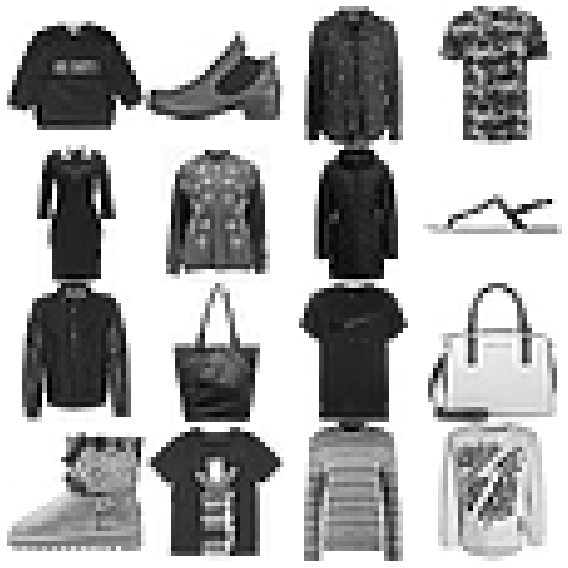

In [8]:
def plot_montage(n):
    '''Plot a montage of the first `n` images.
    '''
    # convert to numpy and squeeze out the color channel
    imgs = images[:n].numpy().squeeze()
    
    # use skimage to make a montage as a single image
    montage = ski.util.montage(imgs)
    
    # plot with matplotlib
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(montage, cmap=plt.cm.gray_r)
    ax.axis('off')
    fig.tight_layout()
    
plot_montage(16);

Next, we use the Kears "subclass" API, i.e., we extend the `keras.Model` class as shown in part three, to build a straightforward Convolutional Neural Network (CNN) to classify our images.

This network consists of a specified number of two-axis convolutions followed by a nonlinear activation function (Rectified Linear by default) followed by a specified number of densely connected layers each followed by a nonlinear activation (Hyperbolic Tangent by default).  Finally, a linear readout layer outputs logits where higher values correspond to higher predicted class membership likelihoods.  Cross entropy will be used as our loss function, so applying a softmax function to the output of the network will yield predicted class membership probabilities.

In [9]:
class ConvNet(keras.Model):
    '''A simple Convolutional Neural Network (CNN) for image classification.
    '''
    def __init__(self, ncls, nconvs, nhiddens, conv_width=3, pool_width=2,
                 conv_activation=keras.activations.relu, hidden_activation=keras.activations.tanh):
        '''Initialize a Convolutional Network for classifying images.
        
        Args:
            ncls:  int
                Number of image classes.
            nconvs:  list(int)
                Number of filters / units in each convolutional layers.
            nhiddens:  list(int)
                Number of hidden units in each dense layer.
            conv_width:  int
                Width of the convolutional kernels, defaults to 3.
            pool_width:  int
                Width of the max pooling layers, defaults to 2.
            conv_activation:  keras.activations.*
                Activation function for convolutional layers,
                defaults to `keras.activations.relu`.
            hidden_activation:  keras.activations.*
                Activation function for dense hidden layers,
                defaults to `keras.activations.tanh`.
        '''
        super().__init__()
        
        # construct each convolutional layer, followed by a max pooling layer
        convs = []
        for i, conv in enumerate(nconvs):
            convs.append(
                keras.layers.Conv2D(
                    filters=conv,
                    kernel_size=conv_width,
                    activation=conv_activation))
            convs.append(
                keras.layers.MaxPooling2D(
                    pool_size=(pool_width, pool_width)))
            
        # pack convolutional layers into a sequential
        self.conv = keras.Sequential(convs, name='conv')
        
        # flatten the result out into a vector for the dense layers
        self.flatten = keras.layers.Flatten(name='flatten')
        
        # create the dense layers and pack into a sequential
        self.hidden = keras.Sequential(
            [keras.layers.Dense(nhidden, activation=hidden_activation) for nhidden in nhiddens],
            name='hidden')
        
        # linear visible / readout layer yields a single output for each class
        self.visible = keras.layers.Dense(ncls, name='visible')
        
    def call(self, images):
        '''Forward pass of our CNN.  Outputs logits with the max corresponding
        to the predicted class labels.  Apply softmax to this output to get
        probability scores in [0, 1], see the `probs` method.
        '''
        conv_out = self.conv(images)
        flat_out = self.flatten(conv_out)
        hidden_out = self.hidden(flat_out)
        visible_out = self.visible(hidden_out)
        
        return visible_out
    
    @tf.function
    def probs(self, images):
        '''Predict class membership probabilities for a batch of images.
        '''
        logits = self(images)
        return keras.activations.softmax(logits)
    
    @tf.function
    def labels(self, images):
        '''Predict class labels for a batch of images. 
        '''
        logits = self(images)
        return tf.argmax(logits, axis=1)

Now that our model class is defined, let's construct a new model with 10 classes, three convolutional layers and two dense layers.

In [10]:
conv_net = ConvNet(ncls=10, nconvs=(16, 24, 32), nhiddens=(24, 16))

We then need to assign an optimizer and loss function.  We use the Adam stochastic gradient descent optimizer, which is a common choice, and `SparseCategoricalCrossentropy` as our loss function, which just means that we are using single-label cross entropy where the target class labels are represented as integer values, as opposed to indicator variables.

We then compile our model, so that it's ready to train.

In [11]:
# use the Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.0015)

# cross entropy loss, the network outputs logits, so compute softmax internally
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model so that its ready to train
conv_net.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy',])

We can also build the model so that we can fix the number of inputs to each layer and examine the number of parameters in each layer.  Note that this is optional and if we don't build the model beforehand, then Keras will determine the number of inputs to each layer durint the first forward pass.

Note that this network has about 10,000 parameters in the convolutional layers, 1,200 in the hidden layers and 170 in the readout layer.  Although this is likely not optimal, it is generally desirable to have most of the parameters in the convolutional layers to prevent overfitting in the dense layers.

In [12]:
# build the model (fix number of inputs to each layer) so that we
# can examine the number of parameters
# this is optional and will be performed lazily during the first
# forward pass if build is not explicitly called
conv_net.build(images.shape)
conv_net.summary()

Model: "conv_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Sequential)            (60000, 1, 1, 32)         10584     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
hidden (Sequential)          (60000, 16)               1192      
_________________________________________________________________
visible (Dense)              multiple                  170       
Total params: 11,946
Trainable params: 11,946
Non-trainable params: 0
_________________________________________________________________


Next, we setup a TensorBoard callback function that we can use to later examine our network and its training performance using TensorBoard.  More on this later, but note that TensorBoard is a standardized tool for examining TensorFlow networks and training performance, and more.

In [13]:
# remove tensorboard logs from previous runs
!rm -rf fashion_logs

# set up a new tensorboard callback and point it to an on-disk logging directory
# this logging directory is where information about the training process will be stored
fashion_logdir = 'fashion_logs/fit/' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(fashion_logdir)

We also set up an early stopping callback using the standard Keras callbacks to limit overfitting.

In [14]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True)

Finally, we can call the `.fit` method on the model to beging the training procedure.

In [15]:
train_result = conv_net.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    callbacks=[early_stopping_cb, tensorboard_cb],
    epochs=50,
    batch_size=128)

Epoch 1/50
  1/391 [..............................] - ETA: 0s - loss: 2.3403 - accuracy: 0.1328

W1004 22:31:32.264075 139708138239808 deprecation.py:323] From /home/idfah/.local/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


391/391 [==============================] - 4s 9ms/step - loss: 0.8297 - accuracy: 0.7265 - val_loss: 0.5602 - val_accuracy: 0.7990
Epoch 2/50
391/391 [==============================] - 3s 9ms/step - loss: 0.5166 - accuracy: 0.8174 - val_loss: 0.4593 - val_accuracy: 0.8390
Epoch 3/50
391/391 [==============================] - 3s 9ms/step - loss: 0.4441 - accuracy: 0.8424 - val_loss: 0.4123 - val_accuracy: 0.8557
Epoch 4/50
391/391 [==============================] - 3s 9ms/step - loss: 0.4003 - accuracy: 0.8568 - val_loss: 0.4023 - val_accuracy: 0.8556
Epoch 5/50
391/391 [==============================] - 3s 9ms/step - loss: 0.3730 - accuracy: 0.8663 - val_loss: 0.3660 - val_accuracy: 0.8675
Epoch 6/50
391/391 [==============================] - 3s 9ms/step - loss: 0.3517 - accuracy: 0.8737 - val_loss: 0.3593 - val_accuracy: 0.8712
Epoch 7/50
391/391 [==============================] - 3s 9ms/step - loss: 0.3378 - accuracy: 0.8798 - val_loss: 0.3558 - val_accuracy: 0.8685
Epoch 8/50
391/39

Now, we can plot a few images from the test set along side with their labels and predicted class membership probabilities in order to verify that the classifier is working.

[('Pullover', 0.4673),
 ('Ankle boot', 0.982),
 ('Coat', 0.5312),
 ('T-shirt/top', 0.6955),
 ('Dress', 0.995),
 ('Shirt', 0.9771),
 ('Coat', 0.9754),
 ('Sandal', 0.9983),
 ('Coat', 0.6824),
 ('Bag', 0.9999),
 ('T-shirt/top', 0.9489),
 ('Bag', 0.9985),
 ('Ankle boot', 0.9881),
 ('T-shirt/top', 0.9242),
 ('Pullover', 0.9842),
 ('Shirt', 0.5723)]

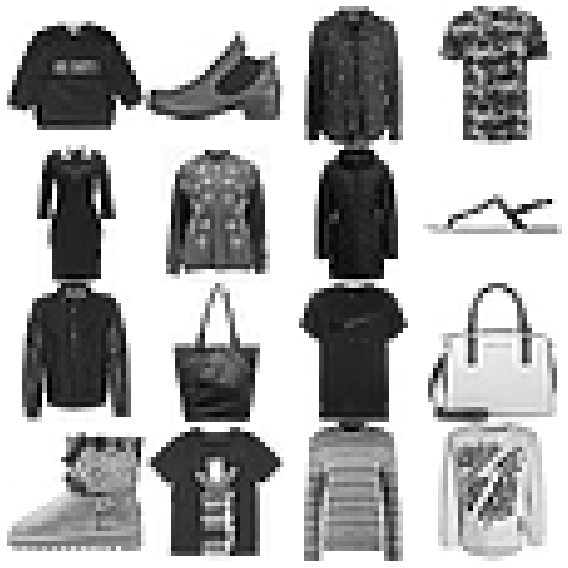

In [16]:
# plot the first 16 images
plot_montage(16)

# predict the class membership for each image
probs = conv_net.probs(test_images[:16])

# predicted labels are the max predicted probs
labels = tf.argmax(probs, axis=1)

# convert labels to strings, round the probs and print in a list for examination
[(label_map[int(label)], round(float(prob[label]), 4)) for label, prob in zip(labels, probs)]

Finally, we can start up a TensorBoard server, which will parse the logs we saved during training and provides a number of useful visualizations, including how the training and validation loss and accuracy vary during the training procedure.  TensorBoard also allows us to visualize the computational graph of our CNN.

In [18]:
%tensorboard --logdir fashion_logs

We how now demonstrated how to build a simple CNN in TensorFlow 2.x for classifying images in the MNIST fashion dataset.  This network does not yet, however, have an optimal configuration and it is possible to improve these classification accuracies considerably.  We leave it as an exercise for the reader to properly tune this network in order to get the best possible results.